## confirm that the local PCs we test as pcQTLs are not global PCs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.stats import spearmanr


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from residualize import calculate_residual
from notebook_helper_functions import *
import annotate_qtls
import get_pcs
import annotate_clusters

from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id ='Lung'


In [2]:
# load in expression and covariates data
expression_path = "{}/{}.v8.normalized_expression.bed".format(config["expression_dir"], tissue_id)
covariates_path = "{}/{}.v8.covariates.txt".format(config["covariates_dir"], tissue_id)
expression_df = pd.read_csv(expression_path, sep='\t')
covariates_df = pd.read_csv(covariates_path, sep='\t', index_col=0).T

# residualize expression
residal_exp = calculate_residual(expression_df[covariates_df.index], covariates_df, center=True)
residal_exp = pd.DataFrame(residal_exp, columns=covariates_df.index, index=expression_df['gene_id'])
residal_exp.reset_index(inplace=True)

# load in pc data
pc_df = load_pc(config, tissue_id).reset_index(drop=True)

In [3]:
def get_global_pc_variances(pc_df, residal_exp):
    sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]
    global_variences = np.zeros((len(pc_df), len(residal_exp)))
    for pc_idx, pc_phenoytpe in tqdm(pc_df.iterrows(), total=len(pc_df)):
        pc_values = pc_phenoytpe[sample_ids].astype('float')
        for expression_idx, expression_phenotype in residal_exp.iterrows():
            expression_values = expression_phenotype[sample_ids].astype('float')
            slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
            global_variences[pc_idx, expression_idx] = r_value**2
    return global_variences

In [39]:
# faster version
def get_global_pc_variances(pc_df, residal_exp):
    sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]
    num_pc = len(pc_df)
    num_expression = len(residal_exp)
    global_variences = np.zeros((num_pc, num_expression))

    # Convert relevant DataFrames to numpy arrays for faster access
    pc_values_array = pc_df[sample_ids].astype('float').to_numpy()
    expression_values_array = residal_exp[sample_ids].astype('float').to_numpy()

    # Center the values by subtracting the mean
    pc_means = pc_values_array.mean(axis=1, keepdims=True)
    expression_means = expression_values_array.mean(axis=1, keepdims=True)

    # Compute standard deviations
    pc_std = pc_values_array.std(axis=1, keepdims=True)
    expression_std = expression_values_array.std(axis=1, keepdims=True)

    # Compute the global variances
    for pc_idx in tqdm(range(num_pc), total=num_pc):
        for expression_idx in range(num_expression):
            # Covariance calculation (using centered values)
            covariance = np.sum((pc_values_array[pc_idx] - pc_means[pc_idx]) * (expression_values_array[expression_idx] - expression_means[expression_idx]))
            r_num = covariance
            r_den = pc_std[pc_idx] * expression_std[expression_idx] * (len(sample_ids) - 1)  # normalization factor

            # Compute the squared correlation coefficient
            if r_den != 0:
                r_squared = (r_num / r_den) ** 2
            else:
                r_squared = 0  # if standard deviation is zero, set to 0 (no correlation)

            global_variences[pc_idx, expression_idx] = r_squared
    return global_variences

In [55]:
# get the pc-expression value for every gene in the cluster
#for chr_id in expression_df['#chr'].unique():

chr_id = 'chr22'
chr_gene_ids = expression_df[expression_df['#chr'] == chr_id]['gene_id']
chr_residal_exp = residal_exp[residal_exp['gene_id'].isin(chr_gene_ids)]
chr_pc_df = pc_df[pc_df['#chr'] == chr_id]
global_variences = get_global_pc_variances(chr_pc_df, chr_residal_exp)


# mask for if the value is in a cluster
in_cluster_mask = np.zeros(global_variences.shape)
for i in range(len(chr_residal_exp)):
    expression_row = chr_residal_exp.iloc[i]
    in_cluster_mask[:,i] = chr_pc_df['gene_id'].str.contains(expression_row['gene_id'])


  0%|          | 0/53 [00:00<?, ?it/s]

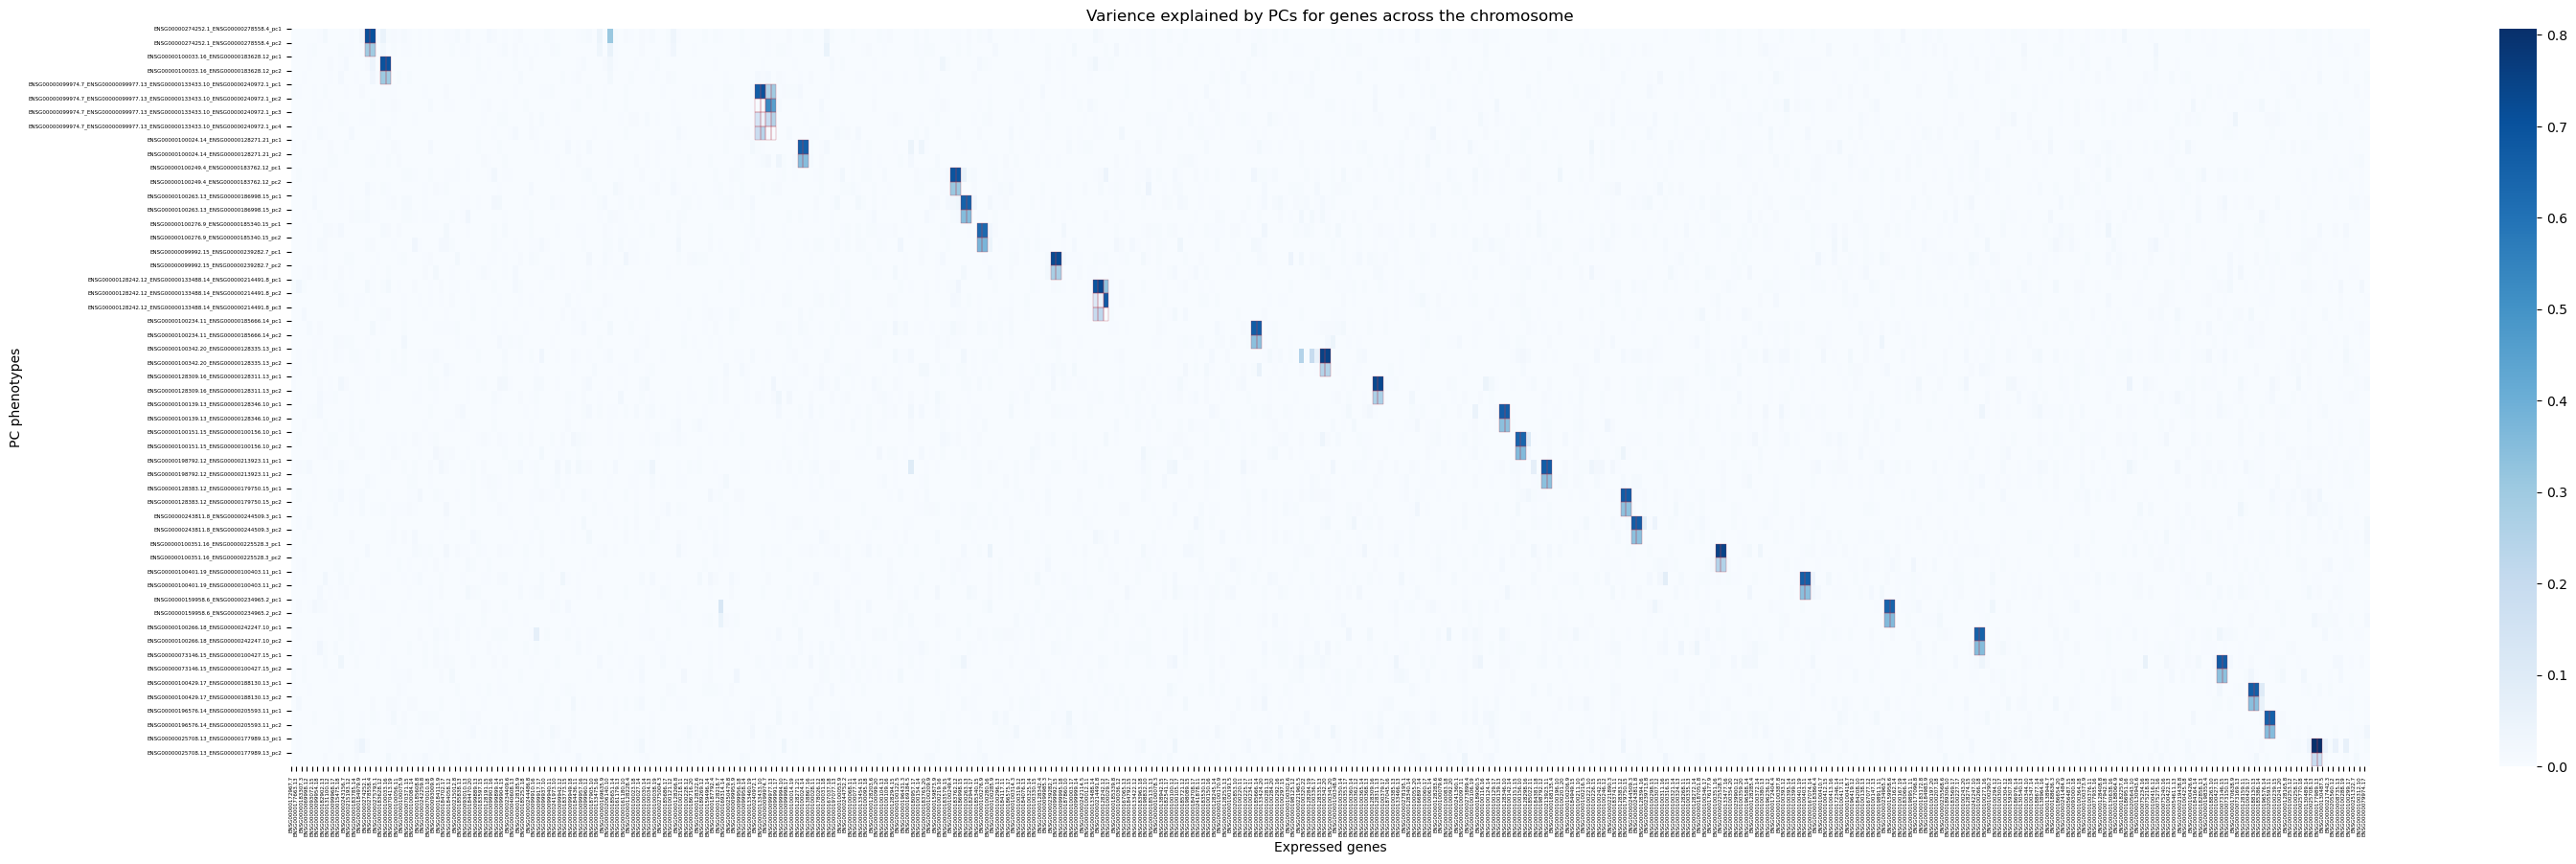

In [56]:
# Create a heatmap
plt.figure(figsize=(35, 10))
ax = sns.heatmap(global_variences, cmap=sns.color_palette("Blues", as_cmap=True), cbar=True)

# Outline cells based on the in_gene_mask
for (i, j), val in np.ndenumerate(in_cluster_mask):
    if val == 1:
        # Draw a rectangle around cells that are 1 in mask_array
        rect = plt.Rectangle((j, i), 1, 1, fill=False, color='#B83A4B', linewidth=.2)
        ax.add_patch(rect)

ax.set_xticks(ticks=range(len(chr_residal_exp)), labels=chr_residal_exp['gene_id'], rotation=90, fontsize=4)
ax.set_yticks(ticks=range(len(chr_pc_df)), labels=chr_pc_df['gene_id'], rotation=0, fontsize=4)


# Set labels and titles
plt.title("Varience explained by PCs for genes across the chromosome")
plt.xlabel("Expressed genes")
plt.ylabel("PC phenotypes")
plt.show()

# look genome wide

In [43]:
small_pc = pc_df.sample(100)
small_exp = residal_exp

global_variences = get_global_pc_variances(small_pc, small_exp)

# mask for if the value is in a cluster
in_cluster_mask = np.zeros(global_variences.shape)
for i in range(len(small_exp)):
    expression_row = small_exp.iloc[i]
    in_cluster_mask[:,i] = small_pc['gene_id'].str.contains(expression_row['gene_id'])

  0%|          | 0/100 [00:00<?, ?it/s]

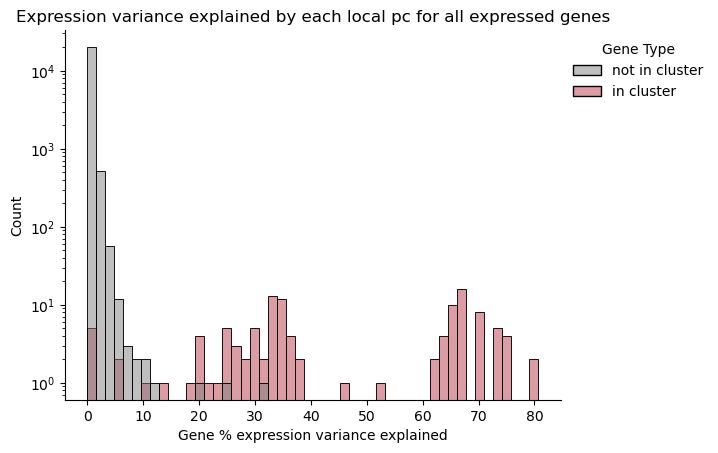

In [59]:
global_variences_df = pd.DataFrame({'r_squared':global_variences.flatten()*100, 'in_cluster_gene':in_cluster_mask.flatten()})
global_variences_df['gene_type'] = np.where(global_variences_df['in_cluster_gene'], 'in cluster', 'not in cluster')
ax = sns.histplot(global_variences_df, x='r_squared', bins=50, hue='gene_type', palette={'in cluster':'#B83A4B', 'not in cluster':'grey'})
ax.set_yscale("log")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Gene % expression variance explained')
ax.set_ylabel('Count')
ax.set_title('Expression variance explained by each local pc for all expressed genes')


# Move and customize the legend
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
legend = ax.get_legend()  # Get the existing legend object
legend.set_title("Gene Type")  # Change the title of the existing legend
legend.set_frame_on(False)  # Remove the frame if needed
